In [2]:
# ====== LIBRARIES ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [3]:
# ====== LOAD DATA ======
df = pd.read_csv("Taiwan Semiconductor Stock Price History.csv")

#Robust fix for inconsistent formats like 07-11-2025
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

df = df.sort_values('Date')



In [4]:
# ====== CLEANING ======
print(df.columns)

# Rename columns for ease of use
df.rename(columns={'Vol.': 'Volume', 'Change %': 'ChangePercent'}, inplace=True)

# Convert ChangePercent and Volume to numeric
df['ChangePercent'] = df['ChangePercent'].str.replace('%', '', regex=False).astype(float)
df['Volume'] = df['Volume'].str.replace('M', 'e6', regex=False).str.replace('K', 'e3', regex=False)
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


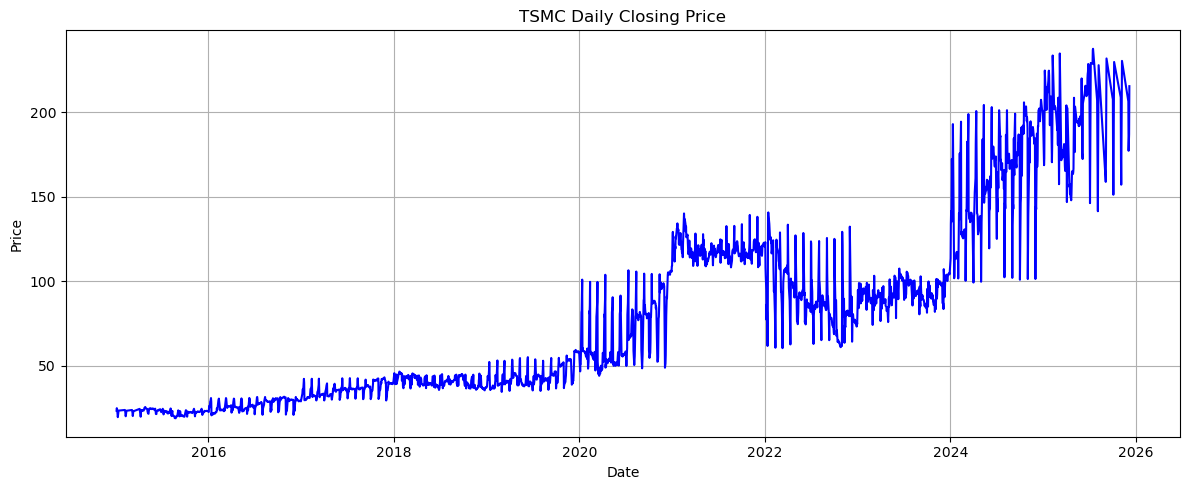

In [5]:
# ====== LINE PLOT ======
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Price'], color='blue')
plt.title("TSMC Daily Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# ====== TRAIN-TEST SPLIT ======
train_size = int(0.8 * len(df))
train, test = df[:train_size], df[train_size:]

C:\Users\hp\AppData\Local\Temp\ipykernel_19696\1614757459.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('Date')['Price'].resample('M').mean()


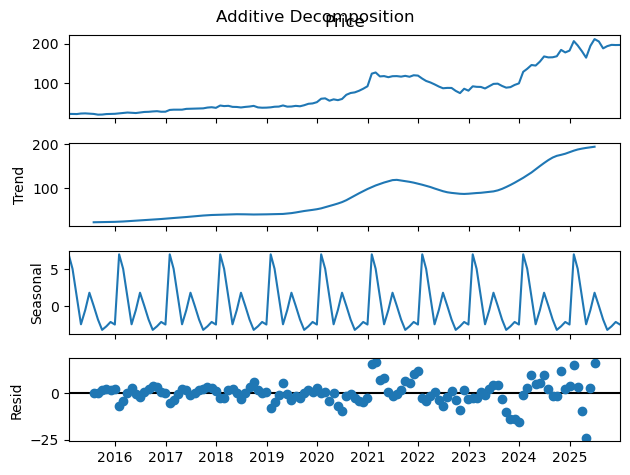

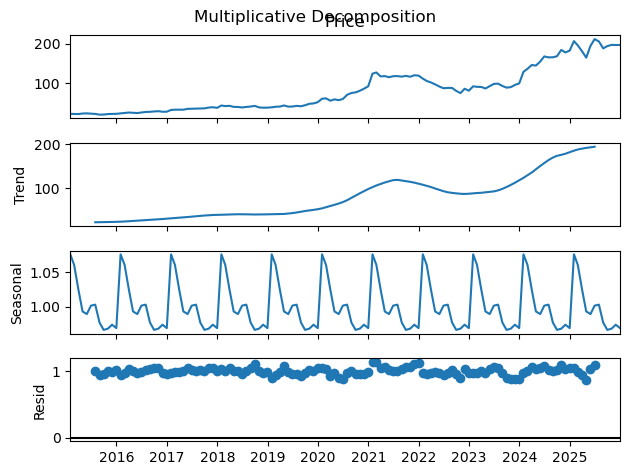

In [7]:
# ====== MONTHLY DECOMPOSITION ======
monthly = df.set_index('Date')['Price'].resample('M').mean()
decomp_add = seasonal_decompose(monthly, model='additive')
decomp_mul = seasonal_decompose(monthly, model='multiplicative')

decomp_add.plot()
plt.suptitle("Additive Decomposition")
plt.show()

decomp_mul.plot()
plt.suptitle("Multiplicative Decomposition")
plt.show()



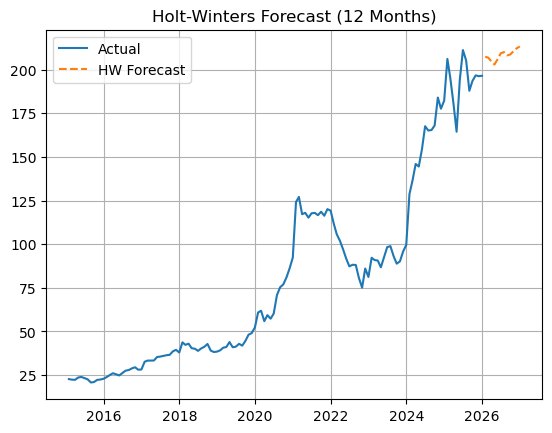

In [8]:
# ====== HOLT-WINTERS FORECAST ======
hw_model = ExponentialSmoothing(monthly, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(12)

plt.plot(monthly, label='Actual')
plt.plot(hw_forecast, label='HW Forecast', linestyle='--')
plt.title("Holt-Winters Forecast (12 Months)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

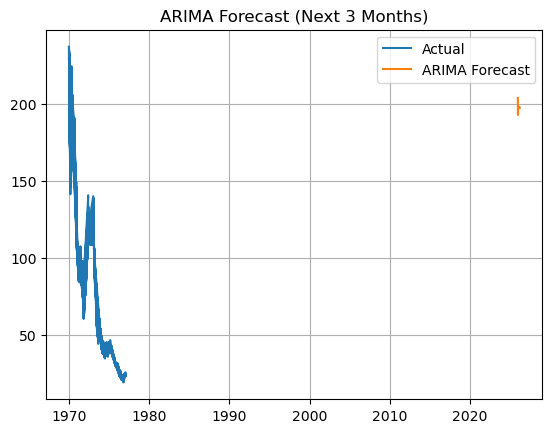

In [9]:
# ====== ARIMA MODEL (DAILY) ======
arima_model = auto_arima(df['Price'], seasonal=False)
arima_fit = ARIMA(df['Price'], order=arima_model.order).fit()
arima_forecast = arima_fit.forecast(90)

plt.plot(df['Price'], label='Actual')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=90, freq='D'), arima_forecast, label='ARIMA Forecast')
plt.title("ARIMA Forecast (Next 3 Months)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

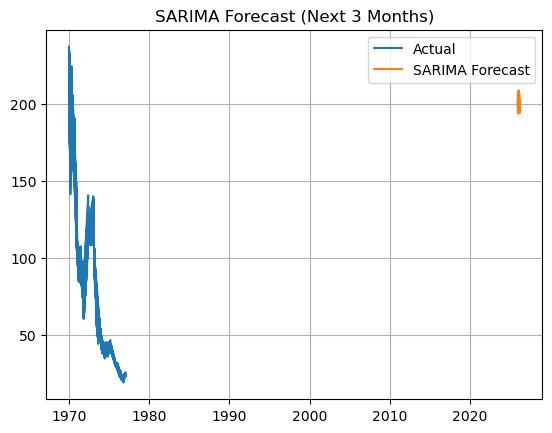

In [10]:
# ====== SARIMA MODEL (DAILY) ======
sarima_model = auto_arima(df['Price'], seasonal=True, m=12)
sarima_fit = ARIMA(df['Price'], order=sarima_model.order, seasonal_order=sarima_model.seasonal_order).fit()
sarima_forecast = sarima_fit.forecast(90)

plt.plot(df['Price'], label='Actual')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=90, freq='D'), sarima_forecast, label='SARIMA Forecast')
plt.title("SARIMA Forecast (Next 3 Months)")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_19696\576622186.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(monthly.index[-1], periods=12, freq='M'), monthly_forecast, label='ARIMA Monthly Forecast')


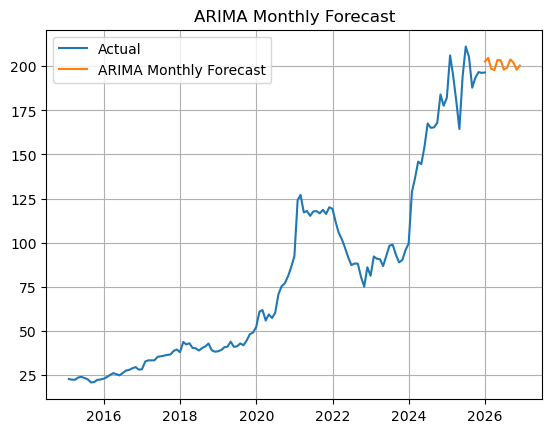

In [11]:
# ====== ARIMA ON MONTHLY SERIES ======
monthly_arima = auto_arima(monthly, seasonal=False)
monthly_fit = ARIMA(monthly, order=monthly_arima.order).fit()
monthly_forecast = monthly_fit.forecast(12)

plt.plot(monthly, label='Actual')
plt.plot(pd.date_range(monthly.index[-1], periods=12, freq='M'), monthly_forecast, label='ARIMA Monthly Forecast')
plt.title("ARIMA Monthly Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# ====== MACHINE LEARNING PREP ======
df['Lag1'] = df['Price'].shift(1)
df['Lag2'] = df['Price'].shift(2)
df_ml = df.dropna()

X = df_ml[['Lag1', 'Lag2']]
y = df_ml['Price']
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [13]:
# ====== DECISION TREE ======
dt_model = DecisionTreeRegressor().fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
print("Decision Tree RMSE:", mean_squared_error(y_test, dt_pred, squared=False))

Decision Tree RMSE: 42.83069796510785


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
# ====== RANDOM FOREST ======
rf_model = RandomForestRegressor().fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest RMSE:", mean_squared_error(y_test, rf_pred, squared=False))

Random Forest RMSE: 42.56348975510979


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
# ====== LSTM PREP ======
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_ml[['Price']])

X_lstm, y_lstm = [], []
for i in range(60, len(scaled)):
    X_lstm.append(scaled[i-60:i])
    y_lstm.append(scaled[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]


In [16]:
# ====== LSTM MODEL ======
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

lstm_pred = model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test_lstm)


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0355
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


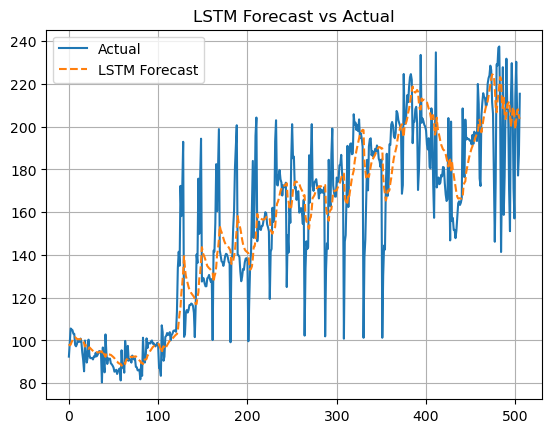

In [17]:
# ====== LSTM PLOT ======
plt.plot(y_test_actual, label='Actual')
plt.plot(lstm_pred, label='LSTM Forecast', linestyle='--')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()